In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import itertools
import math
from statsmodels.tools import eval_measures
from sklearn.metrics import mean_squared_error


In [32]:
# pd.options.display.max_columns = None  #列数
# pd.options.display.max_rows = None     #行数

In [33]:
amount = [11, 5, 4, 7, 16, 6, 5, 7, 13, 6, 5, 7, 12, 5, 4, 6, 9, 5, 5, 11, 29, 21, 17, 20, 27, 13, 
9, 10, 16, 6, 5, 7, 11, 5, 5, 6, 12, 7, 7, 10, 15, 10, 9, 11, 15, 10, 10, 16, 26, 21, 23, 36, 
50, 45, 45, 49, 57, 43, 40, 44, 52, 43, 42, 45, 52, 41, 39, 41, 48, 35, 34, 35, 42, 34, 36, 43, 
55, 48, 54, 65, 80, 70, 74, 85, 101, 89, 88, 90, 100, 87, 88, 89, 104, 89, 89, 90, 106, 96, 94, 
99, 109, 99, 96, 102]
date = pd.date_range('2020-01-01', periods=104, freq ='7D')
data_df = pd.DataFrame({'amount': amount}, date)
data_df.head()

,amount
2020-01-01,11
2020-01-08,5
2020-01-15,4
2020-01-22,7
2020-01-29,16


用statsmodels库里面的seasonal_decompose函数来分解检测时序数据中的季节/周期性

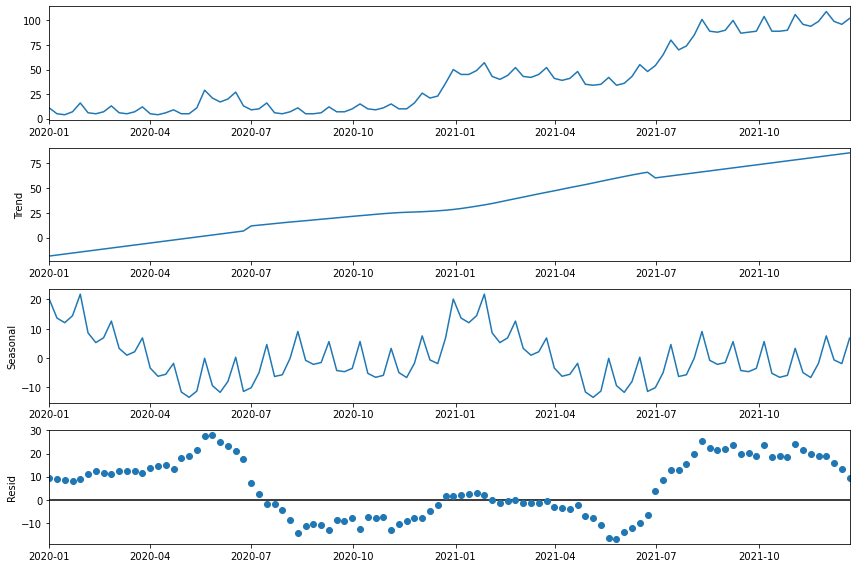

In [34]:
decomposition = sm.tsa.seasonal_decompose(data_df, model='additive', extrapolate_trend='freq')  
plt.rc('figure',figsize=(12,8))
fig = decomposition.plot()
plt.show()

网格搜索选取模型

In [35]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[3]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 0, 2, 12)
SARIMAX: (0, 0, 0) x (0, 0, 3, 12)


In [36]:
best_params = [(0,0,0), (0,0,0,12)]
best_mse = math.inf
test_data = data_df[96:]

for i in pdq:
    for j in seasonal_pdq:
        model = sm.tsa.statespace.SARIMAX(data_df[0:96],
                                order=i,
                                seasonal_order=j,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
        results = model.fit()
        pred = results.get_prediction(start=pd.to_datetime('2021-11-03'), end=pd.to_datetime('2021-12-22'), dynamic=False)
        mse = mean_squared_error(y_true=test_data, y_pred=pred.predicted_mean)
        if mse < best_mse:
            best_mse = mse
            best_params = [i, j]

d:\Environment\python_venv\pinn-demo\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
d:\Environment\python_venv\pinn-demo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
d:\Environment\python_venv\pinn-demo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
d:\Environment\python_venv\pinn-demo\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros

KeyboardInterrupt: 

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(data_df[:96],
                                order=best_params[0],
                                seasonal_order=best_params[1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
best_results = best_model.fit()
best_predict = best_results.get_prediction(start=pd.to_datetime('2021-11-03'), end=pd.to_datetime('2021-12-22'), dynamic=False) #预测值
best_pred_ci = best_predict.conf_int() #置信区间

#画出预测值和真实值的plot图
ax = data_df['2020-01-01':].plot(label='observed')
best_predict.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(best_pred_ci.index, best_pred_ci.iloc[:, 0], best_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('week')
ax.set_ylabel('amount')
plt.legend()
plt.show()

NameError: name 'sm' is not defined